In [207]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.lines as mlines
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelBinarizer
from bs4 import BeautifulSoup
from requests import get
import re

In [2]:
train = pd.read_csv("flight_delays_train.csv")
test = pd.read_csv("flight_delays_test.csv")
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [284]:
train[train['DepTime']>=2360]

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
3558,c-7,c-9,c-6,2400,B6,OAK,IAD,2408,Y
6423,c-9,c-7,c-3,2400,B6,SEA,JFK,2421,N
8189,c-6,c-14,c-2,2435,EV,CVG,AVL,275,Y
11652,c-12,c-9,c-6,2400,US,LAS,OAK,407,N
16603,c-3,c-27,c-7,2400,HP,LAS,ATL,1747,Y
20766,c-5,c-31,c-2,2534,EV,ATL,HSV,151,Y
24350,c-12,c-27,c-2,2400,DL,LAX,CVG,1900,N
27391,c-3,c-23,c-4,2505,EV,ATL,AGS,143,Y
44332,c-7,c-15,c-5,2440,EV,ATL,SHV,552,Y
45796,c-8,c-18,c-4,2447,EV,ATL,JAN,341,Y


In [125]:
X_train, y_train = (train[["Distance", "DepTime"]].values, 
train["dep_delayed_15min"].map({"Y": 1, "N": 0}).values)
X_test = test[["Distance", "DepTime"]].values

X_train_part, X_valid, y_train_part, y_valid = (
    train_test_split(X_train, y_train, test_size=0.3, random_state=17))

scaler = StandardScaler()
X_train_part = scaler.fit_transform(X_train_part)
X_valid = scaler.transform(X_valid)

In [126]:
logit = LogisticRegression()
logit.fit(X_train_part, y_train_part)
logit_valid_pred = logit.predict_proba(X_valid)[:, 1]
roc_auc_score(y_valid, logit_valid_pred)

0.67956914653526068

In [127]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logit.fit(X_train_scaled, y_train)
logit_test_pred = logit.predict_proba(X_test_scaled)[:,1]
pd.Series(logit_test_pred, name="dep_delayed_15min").to_csv('logit_2feat.csv', index_label='id', header=True)

# EDA

In [18]:
def get_int_value(value):
    if type(value) != str:
        return value
    return int(value.replace("c-", ""))

def to_sin(value, max_value):
    angle = 2. * np.pi * get_int_value(value) / max_value
    return np.sin(angle)

def to_cos(value, max_value):
    angle = 2. * np.pi * get_int_value(value) / max_value
    return np.cos(angle)

def convert_time(t):
    h = t / 100
    m = float(t % 100) / 60
    return h + m

In [64]:
def preprocess(X):
    X["Flight"] = X["Origin"] + "-" + X["Dest"]
    X["Hour"] = X["DepTime"] // 100
    X["Month"] = X["Month"].apply(lambda x: x.replace("c-", ""))
    X["DayOfMonth"] = X["DayofMonth"].apply(lambda x: x.replace("c-", ""))
    X = X.drop(["DayofMonth"], axis=1)
    X["DayOfWeek"] = X["DayOfWeek"].apply(lambda x: x.replace("c-", ""))
#     X = X.drop(["Origin", "Dest"], axis=1)
#     X["DayOfWeekSin"] = X["DayOfWeek"].apply(lambda x: to_sin(x, 7))
#     X["DayOfWeekCos"] = X["DayOfWeek"].apply(lambda x: to_cos(x, 7))
#     X = X.drop(["DayOfWeek"], axis=1)
    
#     X["DayOfMonthSin"] = X["DayofMonth"].apply(lambda x: to_sin(x, 31))
#     X["DayOfMonthCos"] = X["DayofMonth"].apply(lambda x: to_cos(x, 31))
#     X = X.drop(["DayofMonth"], axis=1)
    
#     X["MonthSin"] = X["Month"].apply(lambda x: to_sin(x, 12))
#     X["MonthCos"] = X["Month"].apply(lambda x: to_cos(x, 12))
#     X = X.drop(["Month"], axis=1)
    
#     X["DepTimeSin"] = X["DepTime"].apply(lambda x: to_sin(convert_time(x), 24))
#     X["DepTimeCos"] = X["DepTime"].apply(lambda x: to_cos(convert_time(x), 24))
#     X = X.drop(["DepTime"], axis=1)
    
#     X = pd.get_dummies(X, columns=["Flight", "UniqueCarrier"])
    X["state"] = pd.Series(states)
    if "dep_delayed_15min" in X.columns:
        X["dep_delayed_15min"] = X["dep_delayed_15min"].map({"Y": 1, "N":0})
    
    return X

In [65]:
X = preprocess(train.copy())
X.head()

,Month,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,Flight,Hour,DayOfMonth,state
0,8,7,1934,AA,ATL,DFW,732,0,ATL-DFW,19,21,TX
1,4,3,1548,US,PIT,MCO,834,0,PIT-MCO,15,20,FL
2,9,5,1422,XE,RDU,CLE,416,0,RDU-CLE,14,2,OH
3,11,6,1015,OO,DEN,MEM,872,0,DEN-MEM,10,25,TN
4,10,6,1828,WN,MDW,OMA,423,1,MDW-OMA,18,7,NE


In [106]:
# X_train, X_test, y_train, y_test = train_test_split(X.drop(["dep_delayed_15min"], axis=1), X["dep_delayed_15min"], test_size=0.3, random_state=17)
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# logit = LogisticRegression(n_jobs=-1)
# logit.fit(X_train_scaled, y_train)
# y_pred = logit.predict_proba(X_test_scaled)[:, 1]
# roc_auc_score(y_test, y_pred)
# cl = XGBClassifier()
# cl.fit(X_train, y_train)
# y_pred = cl.predict(X_test)
# roc_auc_score(y_test, y_pred)

In [32]:
airports = X["Dest"].unique()

In [52]:
states = [get_state_by_airport_code(x) for x in airports]

Problem with airport: FCA
Problem with airport: YUM
Problem with airport: MQT
problem with adress:  
Problem with airport: ISO
Problem with airport: CLD
problem with adress:  
problem with adress:  
Problem with airport: SCE
problem with adress:  
problem with adress:  
Problem with airport: VIS
problem with adress:  
Problem with airport: PFN
Problem with airport: OXR
Problem with airport: IYK
problem with adress:  
problem with adress:  
Problem with airport: APF
Problem with airport: MCN
Problem with airport: ILG
problem with adress:  
Problem with airport: HKY
Problem with airport: SOP
problem with adress:  
problem with adress:  
Problem with airport: TEX
Problem with airport: VCT


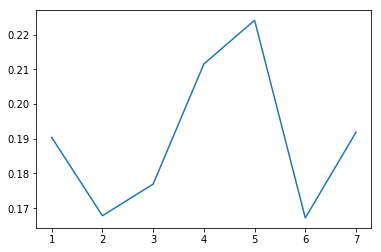

In [74]:
plt.plot(X.groupby("DayOfWeek").agg({"dep_delayed_15min": np.mean}))

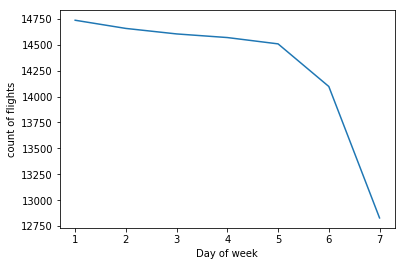

In [88]:
plt.plot(range(1,8), list(X["DayOfWeek"].value_counts()))
plt.xlabel("Day of week")
plt.ylabel("count of flights");

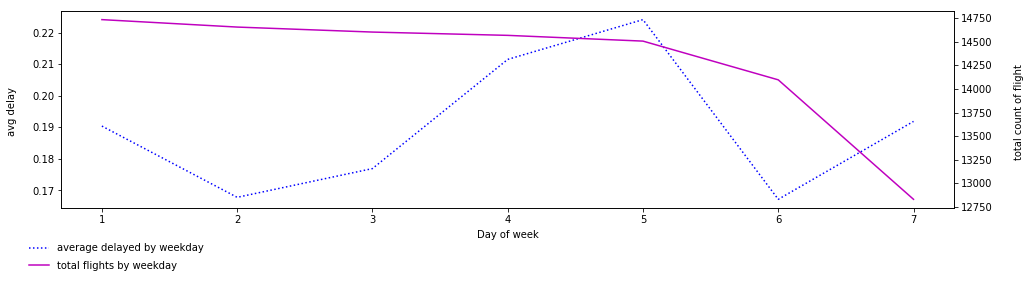

In [266]:
plt.figure(figsize=(16,8))
ax0 = plt.subplot(212)
ax1 = ax0.twinx()
line, = ax0.plot(range(1,8), X.groupby("DayOfWeek").agg({"dep_delayed_15min": np.mean}), 'k:', color='b')
line.set_label("average delayed by weekday")
ax0.legend(bbox_to_anchor=(.17, -0.13), frameon = False)

line2, = ax1.plot(range(1,8), list(X["DayOfWeek"].value_counts()), color='m')
line2.set_label("total flights by weekday")
ax1.legend(bbox_to_anchor=(.14, -0.22), frameon = False)

ax0.text(4, 0.155, 'Day of week', ha='center')
ax0.text(0.3, 0.195, 'avg delay', va='center', rotation='vertical')
ax0.text(7.74, 0.195, 'total count of flight', va='center', rotation='vertical')
plt.show()

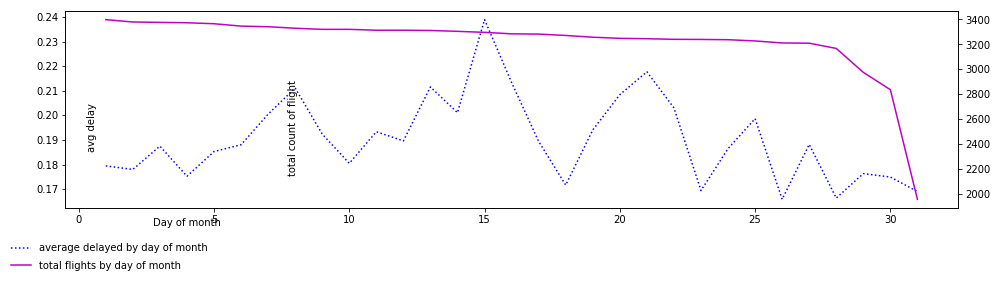

In [271]:
plt.figure(figsize=(16,8))
ax0 = plt.subplot(212)
ax1 = ax0.twinx()
line, = ax0.plot(range(1,32), X.groupby("DayOfMonth").agg({"dep_delayed_15min": np.mean}), 'k:', color='b')
line.set_label("average delayed by day of month")
ax0.legend(bbox_to_anchor=(.17, -0.13), frameon = False)

line2, = ax1.plot(range(1,32), list(X["DayOfMonth"].value_counts()), color='m')
line2.set_label("total flights by day of month")
ax1.legend(bbox_to_anchor=(.14, -0.22), frameon = False)

ax0.text(4, 0.155, 'Day of month', ha='center')
ax0.text(0.3, 0.195, 'avg delay', va='center', rotation='vertical')
ax0.text(7.74, 0.195, 'total count of flight', va='center', rotation='vertical')
plt.show()

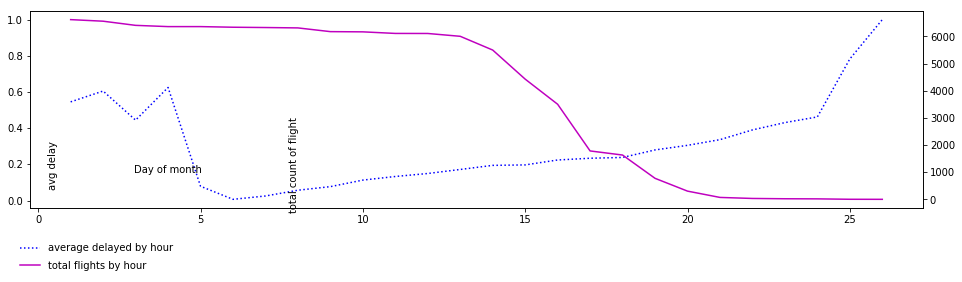

In [275]:
plt.figure(figsize=(16,8))
ax0 = plt.subplot(212)
ax1 = ax0.twinx()
line, = ax0.plot(range(1,27), X.groupby("Hour").agg({"dep_delayed_15min": np.mean}), 'k:', color='b')
line.set_label("average delayed by hour")
ax0.legend(bbox_to_anchor=(.17, -0.13), frameon = False)

line2, = ax1.plot(range(1,27), list(X["Hour"].value_counts()), color='m')
line2.set_label("total flights by hour")
ax1.legend(bbox_to_anchor=(.14, -0.22), frameon = False)

ax0.text(4, 0.155, 'Day of month', ha='center')
ax0.text(0.3, 0.195, 'avg delay', va='center', rotation='vertical')
ax0.text(7.74, 0.195, 'total count of flight', va='center', rotation='vertical')
plt.show()

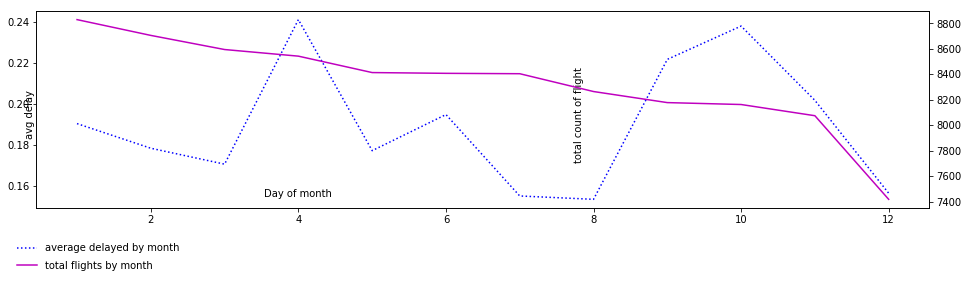

In [285]:
plt.figure(figsize=(16,8))
ax0 = plt.subplot(212)
ax1 = ax0.twinx()
line, = ax0.plot(range(1,13), X.groupby("Month").agg({"dep_delayed_15min": np.mean}), 'k:', color='b')
line.set_label("average delayed by month")
ax0.legend(bbox_to_anchor=(.17, -0.13), frameon = False)

line2, = ax1.plot(range(1,13), list(X["Month"].value_counts()), color='m')
line2.set_label("total flights by month")
ax1.legend(bbox_to_anchor=(.14, -0.22), frameon = False)

ax0.text(4, 0.155, 'Day of month', ha='center')
ax0.text(0.3, 0.195, 'avg delay', va='center', rotation='vertical')
ax0.text(7.74, 0.195, 'total count of flight', va='center', rotation='vertical')
plt.show()

In [289]:
train['dep_delayed_15min'].value_counts()

N    80956
Y    19044
Name: dep_delayed_15min, dtype: int64

In [292]:
X.head()

,Month,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,Flight,Hour,DayOfMonth,state
0,8,7,1934,AA,ATL,DFW,732,0,ATL-DFW,19,21,TX
1,4,3,1548,US,PIT,MCO,834,0,PIT-MCO,15,20,FL
2,9,5,1422,XE,RDU,CLE,416,0,RDU-CLE,14,2,OH
3,11,6,1015,OO,DEN,MEM,872,0,DEN-MEM,10,25,TN
4,10,6,1828,WN,MDW,OMA,423,1,MDW-OMA,18,7,NE


In [356]:
len(np.unique(X['Flight'])), len(np.unique(X['Distance']))

(4429, 1310)

In [360]:
Z = X.groupby("Flight").agg({"Distance": [np.max, np.min]})

In [364]:
np.sum(Z["Distance"]["amax"] - Z["Distance"]["amin"])

0

In [291]:
pd.crosstab(X['dep_delayed_15min'], X['Month'])

Month,1,10,11,12,2,3,4,5,6,7,8,9
dep_delayed_15min,,,,,,,,,,,,
0,6536,6904,6781,6271,6102,6919,7102,7230,6547,6633,7047,6884
1,1539,1501,1397,1994,1316,1676,1306,1313,1867,2073,1783,1279


In [313]:
pd.crosstab(X['dep_delayed_15min'], X['DayOfWeek'], normalize = 'columns')

DayOfWeek,1,2,3,4,5,6,7
dep_delayed_15min,,,,,,,
0,0.809596,0.832169,0.823063,0.788477,0.775875,0.832801,0.808115
1,0.190404,0.167831,0.176937,0.211523,0.224125,0.167199,0.191885


In [315]:
pd.crosstab(X['dep_delayed_15min'], X['DayOfWeek'])

DayOfWeek,1,2,3,4,5,6,7
dep_delayed_15min,,,,,,,
0,11795,12153,11941,11619,11372,10684,11392
1,2774,2451,2567,3117,3285,2145,2705


In [310]:
pd.crosstab(X['Origin'], X['dep_delayed_15min'])

dep_delayed_15min,0,1
Origin,,
ABE,59,8
ABI,20,5
ABQ,424,78
ABY,13,3
ACK,4,1
ACT,27,3
ACV,45,16
ACY,7,1
ADK,0,1


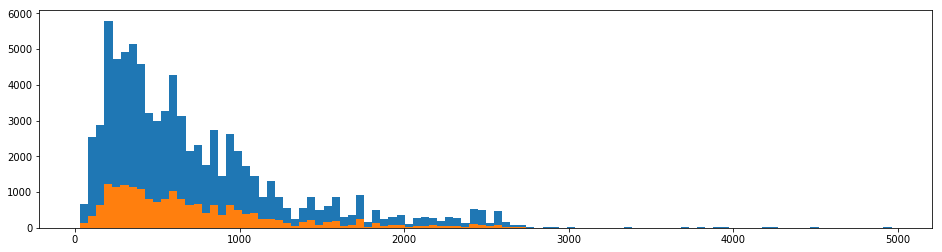

In [366]:
plt.figure(figsize=(16,4))
plt.hist(X['Distance'][X['dep_delayed_15min'] == 0], bins=100)
plt.hist(X['Distance'][X['dep_delayed_15min'] == 1], bins=100)
plt.show()

In [352]:
X['treshhold'] = X['Distance'].apply(lambda x: 1 if (int(x) < 2000) & (int(x) > 65) else 0)

In [353]:
pd.crosstab(X['dep_delayed_15min'], X['treshhold'], normalize = 'columns')

treshhold,0,1
dep_delayed_15min,,
0,0.844727,0.807662
1,0.155273,0.192338


In [351]:
pd.crosstab(X['Distance'], X['dep_delayed_15min'])

dep_delayed_15min,0,1
Distance,,
30,0,1
31,9,4
36,58,8
41,2,1
47,68,5
49,24,8
55,2,0
56,56,6
58,5,1


In [25]:
(X
 .groupby('Origin')
 .agg({'dep_delayed_15min': np.mean})
 .sort_values(by=["dep_delayed_15min"], ascending=False).head())

,dep_delayed_15min
Origin,
GST,1.000000
ADK,1.000000
AKN,1.000000
LWB,0.750000
BRW,0.714286


In [51]:
def get_state_by_airport_code(code):
    url = "https://www.airport.wiki/{airport}/"
    page_source = get(url.format(airport=code)).text
    s = BeautifulSoup(page_source, "lxml")
    fields = s.find_all(name = "div", attrs={'class': 'airport-inner-detail'})
    if not fields or len(fields) <= 2:
        print ("Problem with airport: {code}".format(code=code))
        return "NOT FOUND"
    address = fields[1].text
    try:
        state = address.split(",")[-2].strip().split(" ")[0].strip()
    except:
        print("problem with adress: {a}".format(a=address))
        return "NOT FOUND"
    return state

In [49]:
get_state_by_airport_code("AKN")

'AK'

In [374]:
air = pd.DataFrame(airports, columns=["airport"])
st = pd.DataFrame(states, columns=["state"])

In [379]:
airport_state = pd.concat([air, st], axis=1)

In [ ]:
X